In [12]:
print(gdf_skred.geometry.iloc[0].bounds)

(88612.0, 6469206.25, 88612.25, 6469206.5)


### Vektoranalyse: Sikkerhetssone (Buffer) rundt Tilfluktsrom
I denne analysen ser vi på kritisk infrastruktur i lys av Totalforsvaret. Vi leser inn datasettet for tilfluktsrom. For å kunne lage en geografisk korrekt buffer i meter, må vi først projisere dataene fra WGS84 (lengde-/breddegrader) til UTM Sone 33N (EPSG:25833), som er standard for Norge. Deretter genererer vi en 1000 meters buffer (sikkerhetssone) rundt hvert tilfluktsrom og visualiserer resultatet. Områder innenfor denne radiusen(det grønne feltet) vil være i en sikkersone, dersom akutt fare oppstår hvor tilfluktsrom er aktuellt. 

In [1]:
import folium
import geopandas as gpd

# 1. Les inn datasettet for tilfluktsrom
tilfluktsrom_gdf = gpd.read_file('data/tilfluktsrom.geojson')

# 2. Endre til UTM 33N (for å måle i meter)
tilfluktsrom_utm = tilfluktsrom_gdf.to_crs(epsg=25833)

# 3. Lag en 500 meters buffer (gangavstand/dekningsgrad)
tilfluktsrom_buffer = tilfluktsrom_utm.copy()
tilfluktsrom_buffer['geometry'] = tilfluktsrom_utm.geometry.buffer(500)

# 4. Konverter tilbake til grader for webkartet (WGS84)
tilfluktsrom_buffer_wgs84 = tilfluktsrom_buffer.to_crs(epsg=4326).copy()
tilfluktsrom_punkter_wgs84 = tilfluktsrom_utm.to_crs(epsg=4326).copy()

# Fiks for dato/JSON-problemet vi hadde i stad:
for col in tilfluktsrom_buffer_wgs84.columns:
    if col != 'geometry':
        tilfluktsrom_buffer_wgs84[col] = tilfluktsrom_buffer_wgs84[col].astype(str)

# 5. Lag kartet (Sentrert over Kristiansand-området)
m = folium.Map(location=[58.1467, 8.0182], zoom_start=13, tiles="CartoDB positron")

# 6. Legg til buffersonene (Dekningsområdene i grønt)
folium.GeoJson(
    tilfluktsrom_buffer_wgs84,
    style_function=lambda feature: {
        'fillColor': 'green', 
        'color': 'green', 
        'weight': 1, 
        'fillOpacity': 0.3
    }
).add_to(m)

# 7. Legg til selve tilfluktsrommene som mørkegrønne prikker
for idx, row in tilfluktsrom_punkter_wgs84.iterrows():
    # .centroid finner midtpunktet uansett om det er et punkt eller en bygning!
    punkt = row.geometry.centroid 
    
    # Prøver å hente adresse eller plasser (justert for vanlige kolonnenavn i DSB-data)
    info = row.get('adresse', row.get('plasser', 'Tilfluktsrom'))
    
    folium.CircleMarker(
        location=[punkt.y, punkt.x],
        radius=3,
        color='darkgreen',
        fill=True,
        fill_color='darkgreen',
        popup=str(info) 
    ).add_to(m)

# 8. Vis kartet!
m

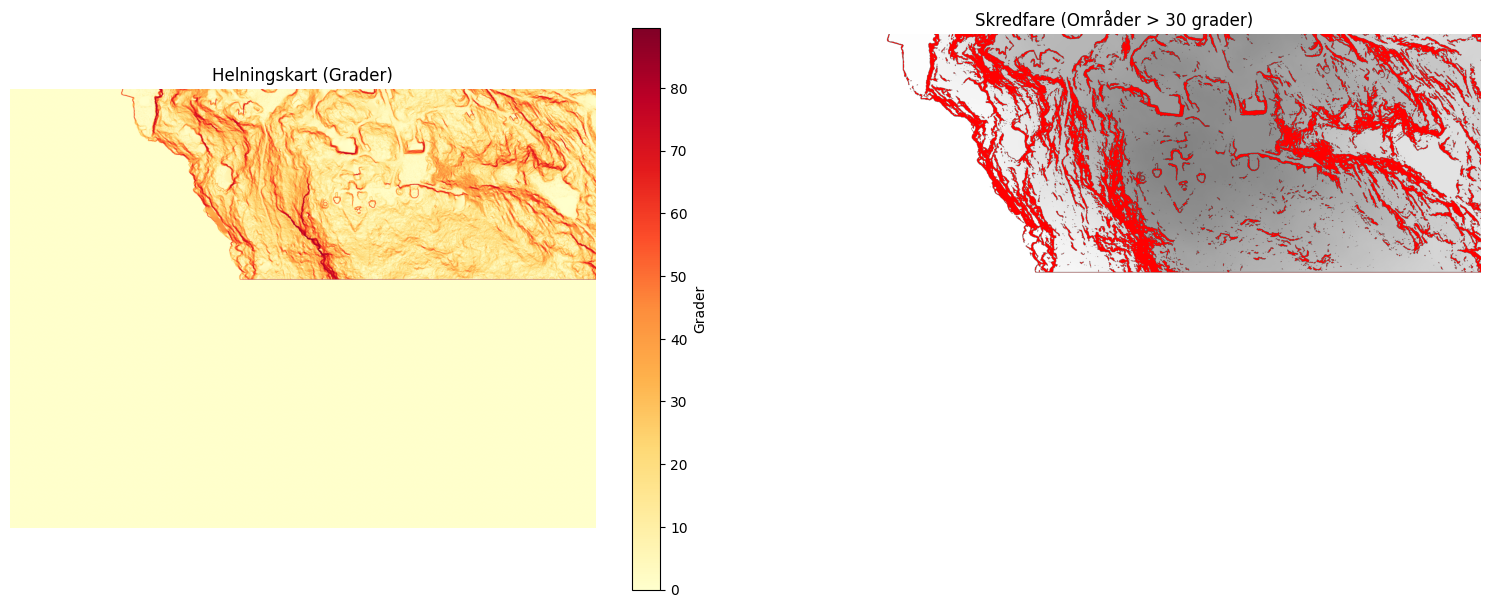

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 1. Åpne høydemodellen (TIF-filen du nettopp lastet ned)
filsti = 'data/hoydedata.tif'

with rasterio.open(filsti) as src:
    # Les inn selve høydedataene som et stort tall-rutenett (numpy-array)
    elev_data = src.read(1).astype('float32')
    
    # Hent oppløsningen (hvor mange meter én piksel representerer)
    cell_size = src.res[0] 
    
    # Rydd bort "tomme" områder rundt kartet (NoData)
    if src.nodata is not None:
        elev_data[elev_data == src.nodata] = np.nan

# 2. Beregn helning (Slope)
# Vi bruker matematikk for å finne høydeforskjellen (gradienten) mellom pikslene
dy, dx = np.gradient(elev_data, cell_size, cell_size)

# Regn ut helningen og konverter til grader
slope_percent = np.sqrt(dx**2 + dy**2)
slope_degrees = np.degrees(np.arctan(slope_percent))

# 3. Filtrer ut områder med skredfare (Brattere enn 30 grader)
skredfare = slope_degrees > 30

# 4. Visualisering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Kart 1: Viser hele terrengets helning i farger
im1 = ax1.imshow(slope_degrees, cmap='YlOrRd')
ax1.set_title('Helningskart (Grader)')
ax1.axis('off')
fig.colorbar(im1, ax=ax1, label='Grader')

# Kart 2: Viser KUN de farlige områdene over 30 grader
# Gjør trygge områder gjennomsiktige for visningen
skredfare_plot = np.where(skredfare, 1, np.nan) 

ax2.imshow(elev_data, cmap='Greys', alpha=0.5) # Terrenget som grå bakgrunn
ax2.imshow(skredfare_plot, cmap='autumn')      # Farlige områder i rødt/gult
ax2.set_title('Skredfare (Områder > 30 grader)')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install rasterio numpy matplotlib

### Del 2: Rasteranalyse - Helning og Skredfare (Totalforsvaret)
I en krisesituasjon (Totalforsvaret) er terreng avgjørende for både fremkommelighet for tunge kjøretøy og for å vurdere skredfare. Vi tar utgangspunkt i en digital høydemodell (DEM) fra Kartverket (Høydedata.no) for et valgt område.

Her dokumenterer vi arbeidsflyten ved bruk av GDAL CLI-kommandoer (Command Line Interface):

**1. Generer helningskart (slope) i grader fra høydemodellen:**
Vi bruker `gdaldem slope` for å regne ut helningen for hver piksel basert på nabopikslene.
`gdaldem slope hoydedata.tif helning.tif -p -of GTiff`

**2. Filtrer ut områder med helning over 30 grader (Skredfare/ufremkommelig):**
Terreng over 30 grader er et klassisk startpunkt for skredfare. Vi bruker `gdal_calc.py` til å lage et binært raster (1 for bratt, 0 for slakt).
`gdal_calc.py -A helning.tif --outfile=bratt_terreng.tif --calc="A>30" --NoDataValue=0`

**3. Konverter de bratte områdene fra raster til vektor (polygonize):**
For å kunne koble de farlige områdene mot annen infrastruktur (vektor), gjør vi pikslene om til polygoner.
`gdal_polygonize.py bratt_terreng.tif bratt_terreng_vektor.gpkg -b 1 -f "GPKG" skredfare_poly Bratt_Grad`

**4. Lag to ulike hillshades (skyggerelieff) for visuell kartlegging:**
Skyggerelieff gjør det lettere å lese terrenget visuelt. Vi lager to versjoner med ulik solhøyde (altitude) og vinkel (azimuth).

*Standard hillshade (sol fra nordvest, 45 grader opp):*
`gdaldem hillshade hoydedata.tif hillshade_standard.tif -z 1.0 -s 1.0 -az 315.0 -alt 45.0`

*Hillshade med lavere sol (20 grader opp, fremhever små terrengdetaljer som gamle skogsveier):*
`gdaldem hillshade hoydedata.tif hillshade_lav_sol.tif -z 1.0 -s 1.0 -az 315.0 -alt 20.0`